# Random Forest with Earth Engine

## Importar pacotes

In [1]:
import geopandas as gpd
import pandas as pd
import random
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

import ee
import geemap
import json

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# importar dados

In [4]:

# df = pd.read_csv('C:/Users/l_v_v/Documents/GitHub/py6s_harmonize_sample/datasets/Landsat Sampling/Merged Landsat Data/Drop Outlier Data/clean_min_data.csv').drop(['Unnamed: 0'],axis=1)
df = pd.read_csv('/content/drive/MyDrive/CURUAI_PROCESS/merge_min_data.csv').drop(['Unnamed: 0'],axis=1)
df.columns

Index(['CHLOROPHYLL', 'CHLOROPHYLL_A', 'CHLOROPHYLL_B', 'CLOUD_COVER',
       'DEPTH_CLASS', 'DOC', 'ID', 'LATITUDE', 'LOCATION', 'LONGITUDE',
       'MISSION', 'N_TOTAL', 'N_TOTAL_DISSOLVED', 'POC', 'P_ORGANIC',
       'P_TOTAL', 'SAMPLE_SITE', 'SAMPLING_DEPTH', 'SILICA', 'SPM', 'TOC',
       'TOTAL_DEPTH', 'TURBIDITY', 'WATER_PERIOD', 'blue_max', 'blue_mean',
       'blue_median', 'blue_min', 'blue_stdDev', 'count_pixel', 'datetime',
       'dif_date_point', 'green_max', 'green_mean', 'green_median',
       'green_min', 'green_stdDev', 'img_date', 'nir_max', 'nir_mean',
       'nir_median', 'nir_min', 'nir_stdDev', 'red_max', 'red_mean',
       'red_median', 'red_min', 'red_stdDev', 'system_index',
       'dif_date_point_abs', 'satellite', 'duplicated'],
      dtype='object')

In [5]:
df = df[['SPM','blue_mean', 'LATITUDE', 'LONGITUDE',
       'green_mean',
       'nir_mean',
       'red_mean',
       'datetime',
       'WATER_PERIOD']].copy()
# retirar valores em branco
df = df.dropna()
df.isna().sum()

,0
SPM,0
blue_mean,0
LATITUDE,0
LONGITUDE,0
green_mean,0
nir_mean,0
red_mean,0
datetime,0
WATER_PERIOD,0


In [6]:
#transform dataframe in a geodataframe (geometry column with point location)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE),
    crs="EPSG:4326"
)
gdf.head()

,SPM,blue_mean,LATITUDE,LONGITUDE,green_mean,nir_mean,red_mean,datetime,WATER_PERIOD,geometry
0,34.4,0.014865,-2.196960,-55.299530,0.025426,0.017437,0.033052,2013-03-09 11:20:00,R,POINT (-55.29953 -2.19696)
1,44.4,0.017526,-2.221738,-55.270194,0.029125,0.012897,0.034728,2013-03-09 13:00:00,R,POINT (-55.27019 -2.22174)
2,44.8,0.013158,-2.209570,-55.347110,0.017679,0.009508,0.021370,2013-03-09 14:35:00,R,POINT (-55.34711 -2.20957)
3,45.2,0.031600,-2.262023,-55.456187,0.038987,0.020354,0.043502,2013-03-11 08:00:00,R,POINT (-55.45619 -2.26202)
4,39.6,0.019097,-2.175347,-55.490867,0.024614,0.012881,0.027611,2013-03-11 11:20:00,R,POINT (-55.49087 -2.17535)


In [7]:
##Convert geodataframe to json - necessary to be read in GEE
dataset_json = gdf.to_json()

In [8]:
#load and select the features of the json data
reg_data = json.loads(dataset_json)
reg_data = reg_data['features']
# data_points

In [9]:
##transform json in in gee object = feature collection
reg_data = ee.FeatureCollection(reg_data)
print(reg_data.size().getInfo())

202


In [10]:
reg_data

## Treinar e fazer tunning do algoritmo

In [11]:
predictors  = ['blue_mean','green_mean','red_mean','nir_mean']
predicted = 'SPM'
numTreesList = ee.List.sequence(100,100, 500)
maxNodesList = ee.List([None,5,10])
variablesPerSplit = ee.List([None,1,2])
minLeafPopulation = ee.List([1,2,5])
bagFraction = ee.List([0.1,0.5,0.8])


In [12]:
def calculateRmse (model) :
  classified = reg_data.classify(classifier= model,
  outputName='SPM_predicted')
  observed = ee.Array(classified.aggregate_array('SPM'));
  predicted = ee.Array(classified.aggregate_array('SPM_predicted'));
  rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0]);
  return rmse

In [13]:
def calculateMAE (model) :
  classified = reg_data.classify(classifier= model,
  outputName='SPM_predicted')
  observed = ee.Array(classified.aggregate_array('SPM'));
  predicted = ee.Array(classified.aggregate_array('SPM_predicted'));
  mae = observed.subtract(predicted).reduce('mean', [0]).get([0]);
  return mae

In [14]:
def calculateR2_score (model) :
  classified = reg_data.classify(classifier= model,
  outputName='SPM_predicted')
  mean = classified.aggregate_mean('SPM')
  obs = classified.map(lambda feat: feat.set('SPM_minus_mean',ee.Number(feat.getNumber('SPM')).subtract(ee.Number(mean))))
  observed = ee.Array(obs.aggregate_array('SPM'));
  predicted = ee.Array(classified.aggregate_array('SPM_predicted'));
  obs_mean = ee.Array(obs.aggregate_array('SPM_minus_mean'));

  ss_res = observed.subtract(predicted).pow(2).reduce('sum', [0]).get([0])

  ss_total = obs_mean.pow(2).reduce('sum', [0]).get([0])

  R2_score = ee.Number(1).subtract(ss_res.divide(ss_total))
  return R2_score

In [15]:
# // Tuning Multiple Parameters
classifiers_list = ee.FeatureCollection(numTreesList
                                        .map(lambda numtrees: maxNodesList
                                             .map(lambda maxnodes: variablesPerSplit
                                                  .map(lambda variablesSplit: minLeafPopulation
                                                       .map(lambda leafPop: bagFraction
                                                            .map(lambda bFraction: ee.Feature(None,{
  'numberOfTrees':numtrees,
  'maxNodes':maxnodes,
  'variablesPerSplit':variablesSplit,
  'minLeafPopulation':leafPop,
  'bagFraction':bFraction,
  'seed':100,
  'rmse':calculateRmse(ee.Classifier.smileRandomForest(
       numberOfTrees= numtrees,
       maxNodes= maxnodes,
       variablesPerSplit = variablesSplit,
      minLeafPopulation = leafPop,
        bagFraction = bFraction,
       seed=100
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      )),
  'mae':calculateMAE(ee.Classifier.smileRandomForest(
       numberOfTrees= numtrees,
       maxNodes= maxnodes,
       variablesPerSplit = variablesSplit,
      minLeafPopulation = leafPop,
        bagFraction = bFraction,
       seed=100
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      )),
  'r2':calculateR2_score(ee.Classifier.smileRandomForest(
       numberOfTrees= numtrees,
       maxNodes= maxnodes,
       variablesPerSplit = variablesSplit,
      minLeafPopulation = leafPop,
        bagFraction = bFraction,
       seed=100
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      )),
  })))))).flatten())
classifiers_list

In [16]:
resultFcSorted = classifiers_list.sort('rmse');
lowest_rmse_feature = resultFcSorted.first();
lowestRMSE = lowest_rmse_feature.getNumber('rmse');
optimalNumTrees = lowest_rmse_feature.getNumber('numberOfTrees');
optimalmaxNodes = lowest_rmse_feature.getNumber('maxNodes');
optimalvariablesPerSplit = lowest_rmse_feature.getNumber('variablesPerSplit');
optimalminLeafPopulation = lowest_rmse_feature.getNumber('minLeafPopulation');
optimalbagFraction = lowest_rmse_feature.getNumber('bagFraction');
lowest_rmse_feature

In [17]:
resultFcSorted = classifiers_list.sort('r2',False);
lowest_r2_feature = resultFcSorted.first();
lowest_r2_feature

In [18]:
#cross-validation
#Generate 5 random numbers between 10 and 30
seedlist = ee.List(random.sample(range(0, 10000), 15))
seedlist

In [19]:
mean_r2 = ee.FeatureCollection(seedlist.map(  lambda seeds: ee.Feature(None,{
                     'r2':calculateR2_score(ee.Classifier.smileRandomForest(
       numberOfTrees= optimalNumTrees,
       maxNodes= optimalmaxNodes,
       variablesPerSplit = optimalvariablesPerSplit,
      minLeafPopulation = optimalminLeafPopulation,
        bagFraction = optimalbagFraction,
       seed=ee.Number(seeds)
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      ))
}))).aggregate_mean('r2')

mean_r2

In [20]:
mean_mae = ee.FeatureCollection(seedlist.map(  lambda seeds: ee.Feature(None,{
                     'mae':calculateMAE(ee.Classifier.smileRandomForest(
       numberOfTrees= optimalNumTrees,
       maxNodes= optimalmaxNodes,
       variablesPerSplit = optimalvariablesPerSplit,
      minLeafPopulation = optimalminLeafPopulation,
        bagFraction = optimalbagFraction,
       seed=ee.Number(seeds)
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      ))
}))).aggregate_mean('mae')
mean_mae

In [21]:
mean_rmse = ee.FeatureCollection(seedlist.map(  lambda seeds: ee.Feature(None,{
                     'rmse':calculateRmse(ee.Classifier.smileRandomForest(
       numberOfTrees= optimalNumTrees,
       maxNodes= optimalmaxNodes,
       variablesPerSplit = optimalvariablesPerSplit,
      minLeafPopulation = optimalminLeafPopulation,
        bagFraction = optimalbagFraction,
       seed=ee.Number(seeds)
     ).setOutputMode('REGRESSION').train(
        features= reg_data,
        classProperty= 'SPM',
        inputProperties= predictors
      ))
}))).aggregate_mean('rmse')
mean_rmse

In [22]:
classifier = ee.Classifier.smileRandomForest(
  numberOfTrees= optimalNumTrees,
  maxNodes= optimalmaxNodes,
  variablesPerSplit = optimalvariablesPerSplit,
  minLeafPopulation = optimalminLeafPopulation,
  bagFraction = optimalbagFraction,
  seed=100).setOutputMode('REGRESSION').train(
    features= reg_data,
    classProperty= 'SPM',
    inputProperties= predictors
  )


In [23]:
def get_relativeImportance(key, val):
  return (ee.Number(val)).divide(sum)

In [24]:
# // Calculate variable importance
importance = ee.Dictionary(classifier.explain().get('importance'))

# // Calculate relative importance
sum = importance.values().reduce(ee.Reducer.sum())

relativeImportance = importance.map(get_relativeImportance).getInfo()
relativeImportance

{'blue_mean': 0.17130154716712184,
 'green_mean': 0.19399327626698254,
 'nir_mean': 0.37767126275286633,
 'red_mean': 0.2570339138130293}

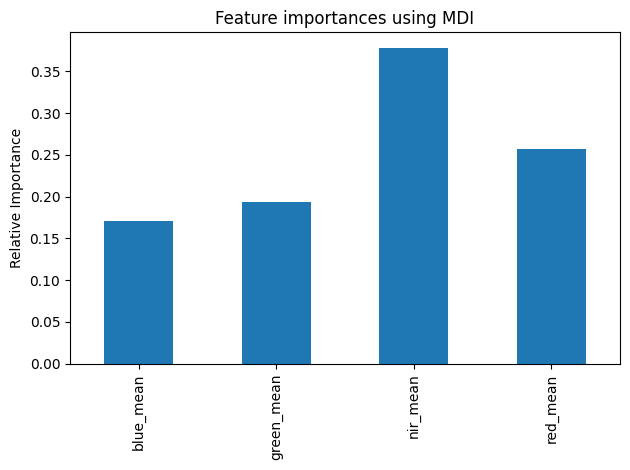

In [25]:
forest_importances = pd.Series(relativeImportance.values(), index=relativeImportance.keys())

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Relative Importance")
fig.tight_layout()

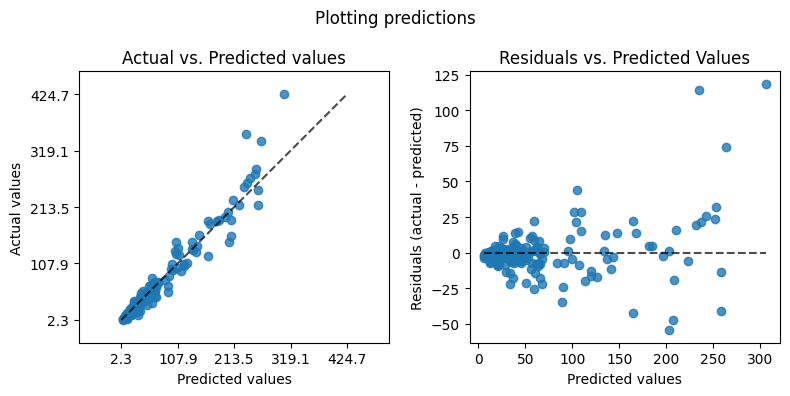

In [26]:
classified_points = geemap.ee_to_df(reg_data.classify(classifier= classifier,
  outputName='SPM_predicted'))

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    classified_points['SPM'],
    y_pred=classified_points['SPM_predicted'],
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    classified_points['SPM'],
    y_pred=classified_points['SPM_predicted'],
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM_predicted'>

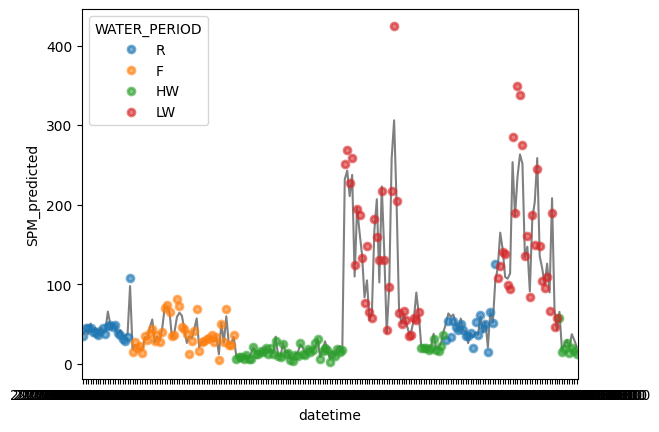

In [27]:
sns.lineplot(data=classified_points, x ='datetime',y= 'SPM_predicted',color='gray')
sns.pointplot(data=classified_points, x ='datetime',y= 'SPM', linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

# Exportar o classificador como asset

In [ ]:
# Create an export classifier task to run.
asset_id = 'projects/ee-curuai/assets/RF_regressor'  # <> modify these
task = ee.batch.Export.classifier.toAsset(
    classifier=classifier,
    description='classifier_export',
    assetId=asset_id
)
task.start()

# Exportar pontos usados no modelo com resultados da predição

In [ ]:
# Export the FeatureCollection to a KML file.
task = ee.batch.Export.table.toDrive(
    collection=reg_data, description='reg', fileFormat='GeoJSON',folder='CURUAI_PROCESS',fileNamePrefix='regression_points'
)
task.start()